## Applies COMMOT to HVGs, SVGs, and unfiltered expression data set for mouse brain ST 

- matches cell barcodes in seurat and HVG/SVG matrices
- creates anndata object for COMMOT input
- runs COMMOT on different LR filtered SVG/HVG/unfiltered genes

author: @emilyekstrum
1/20/26

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import commot as ct
import os
import pyreadr
import rpy2
from rpy2.robjects.packages import importr
import anndata as ad
import copy
from collections import defaultdict
from scipy import sparse
import math
import matplotlib.pyplot as plt

np.random.seed(42)

### Prepare data for COMMOT input
- align by barcode 
- get non negative expression matrix

In [3]:
# load in mouse data HVGs and SVGs - using unLR filtered data
# sorted by p value in ascending order
hvg_gene_cell_mat = os.path.join("/Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/hvgs", "mouse_hvg_gene_cell_matrix.csv")
svg_gene_cell_mat = os.path.join("/Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/svgs", "nnSVG_mouse_svg_gene_cell_matrix.csv")

In [4]:
# check first lines of HVG and SVG gene cell matrices
hvg_df = pd.read_csv(hvg_gene_cell_mat, index_col=0)
svg_df = pd.read_csv(svg_gene_cell_mat, index_col=0)

hvg_df.head() # gene by spot matrix
#svg_df.head()

,AAACAAGTATCTCCCA.1,AAACAGAGCGACTCCT.1,AAACAGGGTCTATATT.1,AAACATTTCCCGGATT.1,AAACCCGAACGAAATC.1,AAACCGGAAATGTTAA.1,AAACCGGGTAGGTACC.1,AAACGAGACGGTTGAT.1,AAACTGCTGGCTCCAA.1,AAACTTGCAAACGTAT.1,...,TTGTGAGGCATGACGC.1,TTGTGCAGCCACGTCA.1,TTGTGGCCCTGACAGT.1,TTGTGTATGCCACCAA.1,TTGTGTTTCCCGAAAG.1,TTGTTAGCAAATTCGA.1,TTGTTCAGTGTGCTAC.1,TTGTTGTGTGTCAAGA.1,TTGTTTCATTAGTCTA.1,TTGTTTCCATACAACT.1
Ttr,1.609438,0.000000,1.098612,0.693147,6.200509,1.609438,1.098612,2.197225,1.791759,0.000000,...,0.693147,1.386294,0.693147,1.386294,1.386294,0.000000,0.000000,1.098612,2.397895,1.098612
Ptgds,2.397895,5.252273,3.871201,2.197225,5.398163,3.555348,2.079442,2.564949,5.176150,3.663562,...,2.079442,2.995732,2.397895,5.991465,6.785588,2.564949,5.135798,1.609438,2.079442,2.772589
Plp1,5.446737,0.693147,4.454347,5.863631,5.003946,4.204693,2.639057,1.791759,2.484907,3.951244,...,2.890372,5.583496,1.386294,4.634729,1.609438,3.044522,2.708050,0.693147,3.850148,4.143135
Pcp2,0.693147,3.583519,0.000000,0.693147,1.386294,0.000000,0.000000,2.079442,1.386294,0.000000,...,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,1.098612,4.158883,0.000000,0.000000
Car8,0.000000,2.639057,0.000000,1.098612,0.693147,0.000000,0.693147,0.693147,0.000000,0.000000,...,0.000000,1.098612,0.000000,0.000000,0.000000,0.000000,0.693147,3.931826,0.693147,0.000000


In [5]:
# convert matrices to gene lists
SVG = set(svg_df.index.tolist())
HVG = set(hvg_df.index.tolist())

In [6]:
# look at lists
print(f"First 10 HVGs: {list(HVG)[:10]}")
print(f"First 10 SVGs: {list(SVG)[:10]}")

First 10 HVGs: ['Spcs3', 'Kdm4c', 'Slc22a15', 'Tmbim1', 'Ddr2', 'Col25a1', 'Myo9b', 'Pik3ip1', 'Plxna4', 'Ylpm1']
First 10 SVGs: ['Spcs3', 'Kdm4c', 'Tmbim1', 'Ddr2', 'Col25a1', 'Myo9b', 'Plxna4', 'Ubl3', 'Ylpm1', 'Hcn2']


In [7]:
# get non negative expression and coordiantes from mouse seurat

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

# load in seurat object
ro.r('library(Seurat)')
ro.r('obj <- readRDS("/Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/seurat_objs/mousebrain_seurat.rds")')

R callback write-console: Loading required package: SeuratObject
  
R callback write-console: Loading required package: sp
  
R callback write-console: 
Attaching package: ‘SeuratObject’

  
R callback write-console: The following objects are masked from ‘package:base’:

    intersect, t

  



    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

In [8]:
# look for images slot
print(ro.r('head(colnames(obj@meta.data), 50)'))  # show first 50 meta columns

 [1] "orig.ident"   "nCount_RNA"   "nFeature_RNA" "cell_id"      "x"           
 [6] "y"            "percent.mt"   "imagerow"     "imagecol"     "nCount_SCT"  
[11] "nFeature_SCT"



In [9]:
# get seurat barcodes
seurat_barcodes = list(ro.r('rownames(obj@meta.data)'))
seurat_barcodes = [str(x) for x in seurat_barcodes]

print("Seurat n spots:", len(seurat_barcodes))
print("CSV n spots:", svg_df.shape[1])

Seurat n spots: 1640
CSV n spots: 1640


In [10]:
# map csv columns to seurat barcodes by order
assert svg_df.shape[1] == len(seurat_barcodes), "Counts differ —> can't map by order"

# rename csv columns to seurat barcodes
svg_df.columns = seurat_barcodes
hvg_df.columns = seurat_barcodes

In [11]:
# Get meta.data with rownames kept as a column
md = ro.r('''
md <- obj@meta.data
md$barcode <- rownames(md)
md[, c("barcode", "cell_id", "imagecol", "imagerow", "x", "y")]
''')
md = pandas2ri.rpy2py(md)

# check types 
md["barcode"] = md["barcode"].astype(str)
md["cell_id"] = md["cell_id"].astype(str)
md = md.dropna(subset=["cell_id"])

# check matches between svg spot ids and meta data cell ids/barcodes
spot_ids_csv = pd.Index(svg_df.columns.astype(str))

# check matches
n_match_cellid = spot_ids_csv.isin(pd.Index(md["cell_id"])).sum()
n_match_barcode = spot_ids_csv.isin(pd.Index(md["barcode"])).sum()

print("CSV -> cell_id matches:", n_match_cellid, "of", len(spot_ids_csv))
print("CSV -> barcode matches:", n_match_barcode, "of", len(spot_ids_csv))

CSV -> cell_id matches: 1640 of 1640
CSV -> barcode matches: 1640 of 1640


In [12]:
# show spot ids
print("CSV examples:", spot_ids_csv[:20].tolist())

CSV examples: ['AAACAAGTATCTCCCA-1', 'AAACAGAGCGACTCCT-1', 'AAACAGGGTCTATATT-1', 'AAACATTTCCCGGATT-1', 'AAACCCGAACGAAATC-1', 'AAACCGGAAATGTTAA-1', 'AAACCGGGTAGGTACC-1', 'AAACGAGACGGTTGAT-1', 'AAACTGCTGGCTCCAA-1', 'AAACTTGCAAACGTAT-1', 'AAAGCTTGCCTACATA-1', 'AAAGTGTGATTTATCT-1', 'AAAGTTGACTCCCGTA-1', 'AAATAAGGTAGTGCCC-1', 'AAATACCTATAAGCAT-1', 'AAATAGCTTAGACTTT-1', 'AAATAGGGTGCTATTG-1', 'AAATCGCGGAAGGAGT-1', 'AAATCTAGCCCTGCTA-1', 'AAATGATTCGATCAGC-1']


In [13]:
# show renamed svg spot ids
print(pd.Index(svg_df.columns.astype(str))[:20].tolist())

# check overlap between seurat barcodes and csv barcodes
seurat_barcodes = pd.Index([str(x) for x in ro.r('colnames(obj)')])
csv_barcodes = pd.Index(svg_df.columns.astype(str))

print("Seurat n:", len(seurat_barcodes))
print("CSV n:", len(csv_barcodes))
print("Overlap:", len(seurat_barcodes.intersection(csv_barcodes)))
print("Seurat example:", seurat_barcodes[:5].tolist())

['AAACAAGTATCTCCCA-1', 'AAACAGAGCGACTCCT-1', 'AAACAGGGTCTATATT-1', 'AAACATTTCCCGGATT-1', 'AAACCCGAACGAAATC-1', 'AAACCGGAAATGTTAA-1', 'AAACCGGGTAGGTACC-1', 'AAACGAGACGGTTGAT-1', 'AAACTGCTGGCTCCAA-1', 'AAACTTGCAAACGTAT-1', 'AAAGCTTGCCTACATA-1', 'AAAGTGTGATTTATCT-1', 'AAAGTTGACTCCCGTA-1', 'AAATAAGGTAGTGCCC-1', 'AAATACCTATAAGCAT-1', 'AAATAGCTTAGACTTT-1', 'AAATAGGGTGCTATTG-1', 'AAATCGCGGAAGGAGT-1', 'AAATCTAGCCCTGCTA-1', 'AAATGATTCGATCAGC-1']
Seurat n: 1640
CSV n: 1640
Overlap: 1640
Seurat example: ['AAACAAGTATCTCCCA-1', 'AAACAGAGCGACTCCT-1', 'AAACAGGGTCTATATT-1', 'AAACATTTCCCGGATT-1', 'AAACCCGAACGAAATC-1']


In [14]:
# get coordinates
coords = ro.r('''
md <- obj@meta.data
md[, c("imagecol","imagerow")]
''')
coords = pandas2ri.rpy2py(coords)
coords.index = coords.index.astype(str)
coords.columns = ["x", "y"]  


print(coords.head()) # cell ID by location

                         x       y
AAACAAGTATCTCCCA-1  7410.0  8455.0
AAACAGAGCGACTCCT-1  3097.0  7905.0
AAACAGGGTCTATATT-1  7050.0  2327.0
AAACATTTCCCGGATT-1  8728.0  8111.0
AAACCCGAACGAAATC-1  6811.0  9351.0


In [15]:
# get counts
expr_df = ro.r('''
mat <- NULL
try({ mat <- GetAssayData(obj, assay="SCT", slot="counts") }, silent=TRUE)
if (is.null(mat)) {
  try({ mat <- GetAssayData(obj, assay="SCT", layer="counts") }, silent=TRUE)
}
if (is.null(mat)) stop("Couldn't access SCT counts.")
as.data.frame(as.matrix(mat))
''')
expr_df = pandas2ri.rpy2py(expr_df)
expr_df.index = expr_df.index.astype(str) # genes
expr_df.columns = expr_df.columns.astype(str)  # barcodes

print("expr_df shape (genes x spots):", expr_df.shape)
print(expr_df.head())  # first 5 spots

expr_df shape (genes x spots): (16112, 1640)
        AAACAAGTATCTCCCA-1  AAACAGAGCGACTCCT-1  AAACAGGGTCTATATT-1  \
Xkr4                   0.0                 0.0                 0.0   
Sox17                  0.0                 0.0                 0.0   
Mrpl15                 0.0                 1.0                 1.0   
Lypla1                 0.0                 0.0                 0.0   
Tcea1                  0.0                 1.0                 0.0   

        AAACATTTCCCGGATT-1  AAACCCGAACGAAATC-1  AAACCGGAAATGTTAA-1  \
Xkr4                   0.0                 0.0                 0.0   
Sox17                  0.0                 0.0                 1.0   
Mrpl15                 0.0                 0.0                 1.0   
Lypla1                 0.0                 0.0                 0.0   
Tcea1                  2.0                 0.0                 0.0   

        AAACCGGGTAGGTACC-1  AAACGAGACGGTTGAT-1  AAACTGCTGGCTCCAA-1  \
Xkr4                   0.0                 

In [16]:
# align by barcodes
common = csv_barcodes.intersection(expr_df.columns).intersection(coords.index)
print("Common spots:", len(common))

# subset to common spots
expr_df = expr_df.loc[:, common]
coords_sub = coords.loc[common]

# nonnegative expression for COMMOT
expr_df = np.log1p(expr_df)

# spots x genes
spot_gene_mat = expr_df.T
print("Spots by gene shape:", spot_gene_mat.shape)

Common spots: 1640
Spots by gene shape: (1640, 16112)


In [17]:
# build AnnData object for COMMOT

adata = ad.AnnData(X=spot_gene_mat.values)
adata.obs_names = spot_gene_mat.index.astype(str)
adata.var_names = spot_gene_mat.columns.astype(str)
adata.obsm["spatial"] = coords_sub.loc[adata.obs_names, ["x","y"]].values

print("adata:", adata.shape)
print("spatial:", adata.obsm["spatial"].shape)
print("X min:", adata.X.min())

adata: (1640, 16112)
spatial: (1640, 2)
X min: 0.0


### Filter for LR pairs using CellChat

In [18]:
# get mouse LR pairs from CellChat
df_lr = ct.pp.ligand_receptor_database(database="CellChat", species="Mouse")

# filter for LR pairs present in data
df_lr_expr = ct.pp.filter_lr_database(df_lr, adata, heteromeric=True, heteromeric_delimiter="_",
                                      heteromeric_rule="min", filter_criteria="min_cell_pct",
                                      min_cell_pct=0.05)

# SVG/HVG filtering
def receptor_in_set(rec, geneset):
    return any(p in geneset for p in str(rec).split("_"))

df_lr_svg = df_lr_expr[df_lr_expr.iloc[:,0].isin(SVG) | df_lr_expr.iloc[:,1].apply(lambda r: receptor_in_set(r, SVG))].copy()
df_lr_hvg = df_lr_expr[df_lr_expr.iloc[:,0].isin(HVG) | df_lr_expr.iloc[:,1].apply(lambda r: receptor_in_set(r, HVG))].copy()

# LR df for unfiltered data
df_lr_unfiltered = ct.pp.filter_lr_database(df_lr, adata, heteromeric=True, heteromeric_delimiter="_",
                                      heteromeric_rule="min", filter_criteria="none")

In [19]:
# look at lr dataframes
print("SVG LR dataframe:")
print(df_lr_svg.head())
print("n LR pairs:", df_lr_svg.shape[0])

SVG LR dataframe:
       0              1     2                   3
0  Tgfb1  Tgfbr1_Tgfbr2  TGFb  Secreted Signaling
1  Tgfb2  Tgfbr1_Tgfbr2  TGFb  Secreted Signaling
2  Tgfb3  Tgfbr1_Tgfbr2  TGFb  Secreted Signaling
3  Tgfb1  Acvr1b_Tgfbr2  TGFb  Secreted Signaling
4  Tgfb1  Acvr1c_Tgfbr2  TGFb  Secreted Signaling
n LR pairs: 169


In [20]:
print("HVG LR dataframe:")
print(df_lr_hvg.head())
print("n LR pairs:", df_lr_hvg.shape[0])

HVG LR dataframe:
       0              1     2                   3
0  Tgfb1  Tgfbr1_Tgfbr2  TGFb  Secreted Signaling
1  Tgfb2  Tgfbr1_Tgfbr2  TGFb  Secreted Signaling
2  Tgfb3  Tgfbr1_Tgfbr2  TGFb  Secreted Signaling
3  Tgfb1  Acvr1b_Tgfbr2  TGFb  Secreted Signaling
4  Tgfb1  Acvr1c_Tgfbr2  TGFb  Secreted Signaling
n LR pairs: 169


In [21]:
print("Unfiltered LR dataframe:")
print(df_lr_unfiltered.head())
print("n LR pairs:", df_lr_unfiltered.shape[0])

Unfiltered LR dataframe:
       0              1     2                   3
0  Tgfb1  Tgfbr1_Tgfbr2  TGFb  Secreted Signaling
1  Tgfb2  Tgfbr1_Tgfbr2  TGFb  Secreted Signaling
2  Tgfb3  Tgfbr1_Tgfbr2  TGFb  Secreted Signaling
3  Tgfb1  Acvr1b_Tgfbr2  TGFb  Secreted Signaling
4  Tgfb1  Acvr1c_Tgfbr2  TGFb  Secreted Signaling
n LR pairs: 589


TGF-beta signaling is highly enriched in SVGs, HVGs, and the unfiltered expression datasets. In the context of the brain, this pathway in involved in neuronal development, microgial function, synaptic plasticity, and injury response. This pathway also plays a role in cell growth, differentiation, and axon guidance. 

In [22]:
# ligand/receptor columns
lig_col = df_lr.columns[0]
rec_col = df_lr.columns[2]

print(f"First 10 ligand names: {df_lr[lig_col].dropna().astype(str).tolist()[:10]}")
print(f"First 10 receptor names: {df_lr[rec_col].dropna().astype(str).tolist()[:10]}")

def split_parts(x):
    if pd.isna(x):
        return []
    # if receptor stored as list/tuple/set
    if isinstance(x, (list, tuple, set)):
        parts = []
        for y in x:
            parts.extend(str(y).split("_"))
        return parts
    return str(x).split("_")

lr_ligands = set(df_lr[lig_col].dropna().astype(str))
lr_receptors = set(p for r in df_lr[rec_col].dropna() for p in split_parts(r))
lr_genes = lr_ligands | lr_receptors

print("Using columns:", lig_col, rec_col)
print("LR genes:", len(lr_genes))
print("LR ∩ SVG:", len(lr_genes & SVG))
print("LR ∩ HVG:", len(lr_genes & HVG))
print("LR ∩ SVG ∩ HVG:", len(lr_genes & SVG & HVG))
print("SVG-only within LR:", len((lr_genes & SVG) - HVG))
print("HVG-only within LR:", len((lr_genes & HVG) - SVG))


First 10 ligand names: ['Tgfb1', 'Tgfb2', 'Tgfb3', 'Tgfb1', 'Tgfb1', 'Tgfb2', 'Tgfb2', 'Tgfb3', 'Tgfb3', 'Tgfb1']
First 10 receptor names: ['TGFb', 'TGFb', 'TGFb', 'TGFb', 'TGFb', 'TGFb', 'TGFb', 'TGFb', 'TGFb', 'TGFb']
Using columns: 0 2
LR genes: 502
LR ∩ SVG: 69
LR ∩ HVG: 93
LR ∩ SVG ∩ HVG: 64
SVG-only within LR: 5
HVG-only within LR: 29


In [23]:
# colnames in lr df
LIG = "0"
REC = "1"
PATH = "2"
CAT = "3"  

# make copies & ensure strings
lr_df = df_lr.copy()
lr_df[LIG] = lr_df[LIG].astype(str)
lr_df[REC] = lr_df[REC].astype(str)

varset = set(adata.var_names)

def receptor_parts(rec: str):
    # heteromeric receptors are encoded as "A_B_C"
    return str(rec).split("_")

def receptor_in_var(rec: str) -> bool:
    parts = receptor_parts(rec)
    return any(p in varset for p in parts)

def receptor_in_set(rec: str, geneset: set) -> bool:
    parts = receptor_parts(rec)
    return any(p in geneset for p in parts)

# filter LR pairs to those present in the dataset
lr_expr = lr_df[
    lr_df[LIG].isin(varset) &
    lr_df[REC].apply(receptor_in_var)
].copy()

# SVG / HVG LR filters 
lr_svg = lr_expr[
    lr_expr[LIG].isin(SVG) |
    lr_expr[REC].apply(lambda r: receptor_in_set(r, SVG))
].copy()

lr_hvg = lr_expr[
    lr_expr[LIG].isin(HVG) |
    lr_expr[REC].apply(lambda r: receptor_in_set(r, HVG))
].copy()

print("LR total:", lr_df.shape)
print("LR expressed in data:", lr_expr.shape)
print("LR SVG-filtered:", lr_svg.shape)
print("LR HVG-filtered:", lr_hvg.shape)


LR total: (1209, 4)
LR expressed in data: (596, 4)
LR SVG-filtered: (484, 4)
LR HVG-filtered: (519, 4)


## Use stricter rules on LR filtering pairings
- ligand and receptor must be an SVG or HVG
- ligand must be a SVG or HVG
- receptor must be a SVG or HVG
- prevalence:
    - ligand and at least one receptor part expressed in at least 5% of spots

In [24]:
# filter based on LR both must be SVG or HVG
lr_svg_strict = lr_expr[
    lr_expr[LIG].isin(SVG) &
    lr_expr[REC].apply(lambda r: all(p in SVG for p in receptor_parts(r)))
].copy()

lr_hvg_strict = lr_expr[
    lr_expr[LIG].isin(HVG) &
    lr_expr[REC].apply(lambda r: all(p in HVG for p in receptor_parts(r)))
].copy()

print("LR SVG-strict filtered:", lr_svg_strict.shape)
print("LR HVG-strict filtered:", lr_hvg_strict.shape)

LR SVG-strict filtered: (116, 4)
LR HVG-strict filtered: (152, 4)


In [25]:
# filter based on ligand must be SVG or HVG
lr_svg_ligand = lr_expr[lr_expr[LIG].isin(SVG)].copy()
lr_hvg_ligand = lr_expr[lr_expr[LIG].isin(HVG)].copy()
lr_ligand = lr_expr.copy()

print("LR SVG-ligand filtered:", lr_svg_ligand.shape)
print("LR HVG-ligand filtered:", lr_hvg_ligand.shape)

LR SVG-ligand filtered: (250, 4)
LR HVG-ligand filtered: (321, 4)


In [26]:
# filter based on receptor must be SVG or HVG
lr_svg_receptor = lr_expr[lr_expr[REC].apply(lambda r: receptor_in_set(r, SVG))].copy()
lr_hvg_receptor = lr_expr[lr_expr[REC].apply(lambda r: receptor_in_set(r, HVG))].copy()

print("LR SVG-receptor filtered:", lr_svg_receptor.shape)
print("LR HVG-receptor filtered:", lr_hvg_receptor.shape)

LR SVG-receptor filtered: (421, 4)
LR HVG-receptor filtered: (450, 4)


In [27]:
# filter based on prevalence: ligand and at least one receptor part expressed in at least 5% of spots
Xdf = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)
pct_expr = (Xdf > 0).mean(axis=0)

min_pct = 0.05  # 5% of spots

def pair_prevalence_ok(df):
    lig_ok = df[LIG].map(lambda g: pct_expr.get(g, 0) >= min_pct)
    rec_ok = df[REC].map(lambda r: any(pct_expr.get(p, 0) >= min_pct for p in receptor_parts(r)))
    return df[lig_ok & rec_ok].copy()

prevalence_lr_expr = pair_prevalence_ok(lr_expr)
prevalence_lr_svg = pair_prevalence_ok(lr_svg)
prevalence_lr_hvg = pair_prevalence_ok(lr_hvg)

print("After prevalence filtering:")
print("LR expressed in data:", prevalence_lr_expr.shape)
print("LR SVG-filtered:", prevalence_lr_svg.shape)
print("LR HVG-filtered:", prevalence_lr_hvg.shape)

After prevalence filtering:
LR expressed in data: (261, 4)
LR SVG-filtered: (256, 4)
LR HVG-filtered: (261, 4)


## Apply OT

## SVGs
- simple SVGs
- L&R SVG
- Ligand SVG
- Receptor SVG
- 5% prevalence

In [28]:
# SVG LR sets
svg_lr_sets = {
    "simple_svg": lr_svg,
    "LR_svg" : lr_svg_strict,
    "L_svg" : lr_svg_ligand,
    "R_svg" : lr_svg_receptor,
    "prevalence_svg" : prevalence_lr_svg,
}

svg_results = {}

# run COMMOT for each LR set
for name, df in svg_lr_sets.items():
    ad = adata.copy()  # use shallow copy
    ct.tl.spatial_communication(
        adata=ad,
        database_name="cellchat",
        df_ligrec=df,
        dis_thr=500,
        heteromeric=True,
        pathway_sum=True,
    )
    # store results
    svg_results[name] = ad

print(svg_results.keys())


dict_keys(['simple_svg', 'LR_svg', 'L_svg', 'R_svg', 'prevalence_svg'])


In [29]:
# save results
output_dir = "/Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/mouse_svg_lr_sets"
os.makedirs(output_dir, exist_ok=True)
for name, ad in svg_results.items():
    output_path = os.path.join(output_dir, f"mouse_commot_{name}.h5ad")
    ad.write_h5ad(output_path)
    print(f"Saved {name} results to {output_path}")

Saved simple_svg results to /Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/mouse_svg_lr_sets/mouse_commot_simple_svg.h5ad
Saved LR_svg results to /Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/mouse_svg_lr_sets/mouse_commot_LR_svg.h5ad
Saved L_svg results to /Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/mouse_svg_lr_sets/mouse_commot_L_svg.h5ad
Saved R_svg results to /Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/mouse_svg_lr_sets/mouse_commot_R_svg.h5ad
Saved prevalence_svg results to /Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/mouse_svg_lr_sets/mouse_commot_prevalence_svg.h5ad


In [30]:
# look at COMMOT outputs for SVG sets

def commot_inventory(ad):
    return {
        "n_obs": ad.n_obs,
        "n_vars": ad.n_vars,
        "n_obsp": len(ad.obsp.keys()),
        "obsp_keys_head": list(ad.obsp.keys())[:15],
        "uns_keys_head": list(ad.uns.keys())[:15],
    }

print("COMMOT results for SVG LR sets:")
for name, ad in svg_results.items():
    inv = commot_inventory(ad)
    print("\n==", name, "==")
    print("n_obsp:", inv["n_obsp"])
    print("obsp head:", inv["obsp_keys_head"])


COMMOT results for SVG LR sets:

== simple_svg ==
n_obsp: 539
obsp head: ['commot-cellchat-Gdf10-Acvr1b_Acvr2a', 'commot-cellchat-Ntf3-Ntrk3', 'commot-cellchat-Ntf3-Ntrk2', 'commot-cellchat-Edn3-Ednrb', 'commot-cellchat-Mstn-Acvr1b_Acvr2a', 'commot-cellchat-Mstn-Acvr1b_Acvr2b', 'commot-cellchat-Mstn-Tgfbr1_Acvr2a', 'commot-cellchat-Mstn-Tgfbr1_Acvr2b', 'commot-cellchat-Cxcl5-Ackr1', 'commot-cellchat-Trh-Trhr', 'commot-cellchat-Vegfb-Flt1', 'commot-cellchat-Kitl-Kit', 'commot-cellchat-Wnt3-Fzd7_Lrp6', 'commot-cellchat-Wnt3-Fzd9_Lrp6', 'commot-cellchat-Wnt3-Fzd1_Lrp6']

== LR_svg ==
n_obsp: 156
obsp head: ['commot-cellchat-Wnt7a-Fzd7_Lrp6', 'commot-cellchat-Wnt7a-Fzd3_Lrp6', 'commot-cellchat-Wnt7a-Fzd1_Lrp6', 'commot-cellchat-Wnt7a-Fzd2_Lrp6', 'commot-cellchat-Fgf9-Fgfr2', 'commot-cellchat-Fgf9-Fgfr1', 'commot-cellchat-Fgf9-Fgfr3', 'commot-cellchat-Gdf10-Acvr1b_Acvr2a', 'commot-cellchat-Tgfb3-Acvr1_Tgfbr1_Tgfbr2', 'commot-cellchat-Tgfb3-Acvr1b_Tgfbr2', 'commot-cellchat-Tgfb3-Tgfbr1_Tgfbr

In [31]:
# pathway-sum matrices vs LR pair matrices

def split_pathway_lr_keys(ad):
    keys = list(ad.obsp.keys())
    # pathway matrices typically have much larger nnz and fewer keys overall;
    # also often contain "pathway" or "sum" in key names (depends on version).
    path_keys = [k for k in keys if ("path" in k.lower()) or ("sum" in k.lower())]
    # fallback: if that fails, treat everything as LR and you can manually adjust later
    if len(path_keys) == 0:
        path_keys = []
    lr_keys = [k for k in keys if k not in path_keys]
    return path_keys, lr_keys

print("Pathway vs LR matrices for SVG LR sets:")
for name, ad in  svg_results.items():
    pk, lk = split_pathway_lr_keys(ad)
    print(name, "path:", len(pk), "lr:", len(lk))


Pathway vs LR matrices for SVG LR sets:
simple_svg path: 0 lr: 539
LR_svg path: 0 lr: 156
L_svg path: 0 lr: 296
R_svg path: 0 lr: 469
prevalence_svg path: 0 lr: 297


In [32]:
# rank pathways by total communication strength
def rank_obsp_by_total(ad, keys=None):
    if keys is None:
        keys = list(ad.obsp.keys())
    rows = []
    for k in keys:
        M = ad.obsp[k]
        total = M.sum() if sparse.issparse(M) else np.sum(M)
        rows.append((k, float(total)))
    rows.sort(key=lambda x: x[1], reverse=True)
    return rows

print("Top pathways by total communication strength for SVG LR sets:")
for name, ad in svg_results.items():
    pk, lk = split_pathway_lr_keys(ad)
    keys_to_rank = pk if len(pk) > 0 else lk
    top = rank_obsp_by_total(ad, keys_to_rank)[:10]
    print("\nTOP in", name)
    for k, s in top:
        print(f"{s: .3e}", k)


Top pathways by total communication strength for SVG LR sets:

TOP in simple_svg
 2.358e+04 commot-cellchat-total-total
 3.914e+03 commot-cellchat-PSAP
 3.220e+03 commot-cellchat-PTN
 2.554e+03 commot-cellchat-Psap-Gpr37l1
 2.300e+03 commot-cellchat-FGF
 1.694e+03 commot-cellchat-MK
 1.360e+03 commot-cellchat-Psap-Gpr37
 1.120e+03 commot-cellchat-VEGF
 8.978e+02 commot-cellchat-GAS
 8.791e+02 commot-cellchat-WNT

TOP in LR_svg
 2.011e+04 commot-cellchat-total-total
 3.914e+03 commot-cellchat-PSAP
 3.189e+03 commot-cellchat-PTN
 2.554e+03 commot-cellchat-Psap-Gpr37l1
 2.107e+03 commot-cellchat-FGF
 1.660e+03 commot-cellchat-MK
 1.360e+03 commot-cellchat-Psap-Gpr37
 1.025e+03 commot-cellchat-VEGF
 8.573e+02 commot-cellchat-GAS
 8.388e+02 commot-cellchat-Ptn-Ncl

TOP in L_svg
 2.130e+04 commot-cellchat-total-total
 3.914e+03 commot-cellchat-PSAP
 3.229e+03 commot-cellchat-PTN
 2.554e+03 commot-cellchat-Psap-Gpr37l1
 2.107e+03 commot-cellchat-FGF
 1.695e+03 commot-cellchat-MK
 1.360e+03 co

In [33]:
# per spot LR sender and receiver scores
def add_sender_receiver(ad, key, prefix):
    M = ad.obsp[key]
    out = np.array(M.sum(axis=1)).ravel()
    inn = np.array(M.sum(axis=0)).ravel()
    ad.obs[f"{prefix}__out"] = out
    ad.obs[f"{prefix}__in"] = inn
    return out, inn

print("Adding top 3 sender/receiver scores for SVG LR sets")
for name, ad in svg_results.items():
    pk, lk = split_pathway_lr_keys(ad)
    keys_to_rank = pk if len(pk) > 0 else lk
    top3 = [k for k, _ in rank_obsp_by_total(ad, keys_to_rank)[:3]]
    for i, k in enumerate(top3, 1):
        add_sender_receiver(ad, k, prefix=f"{name}_top{i}")


Adding top 3 sender/receiver scores for SVG LR sets


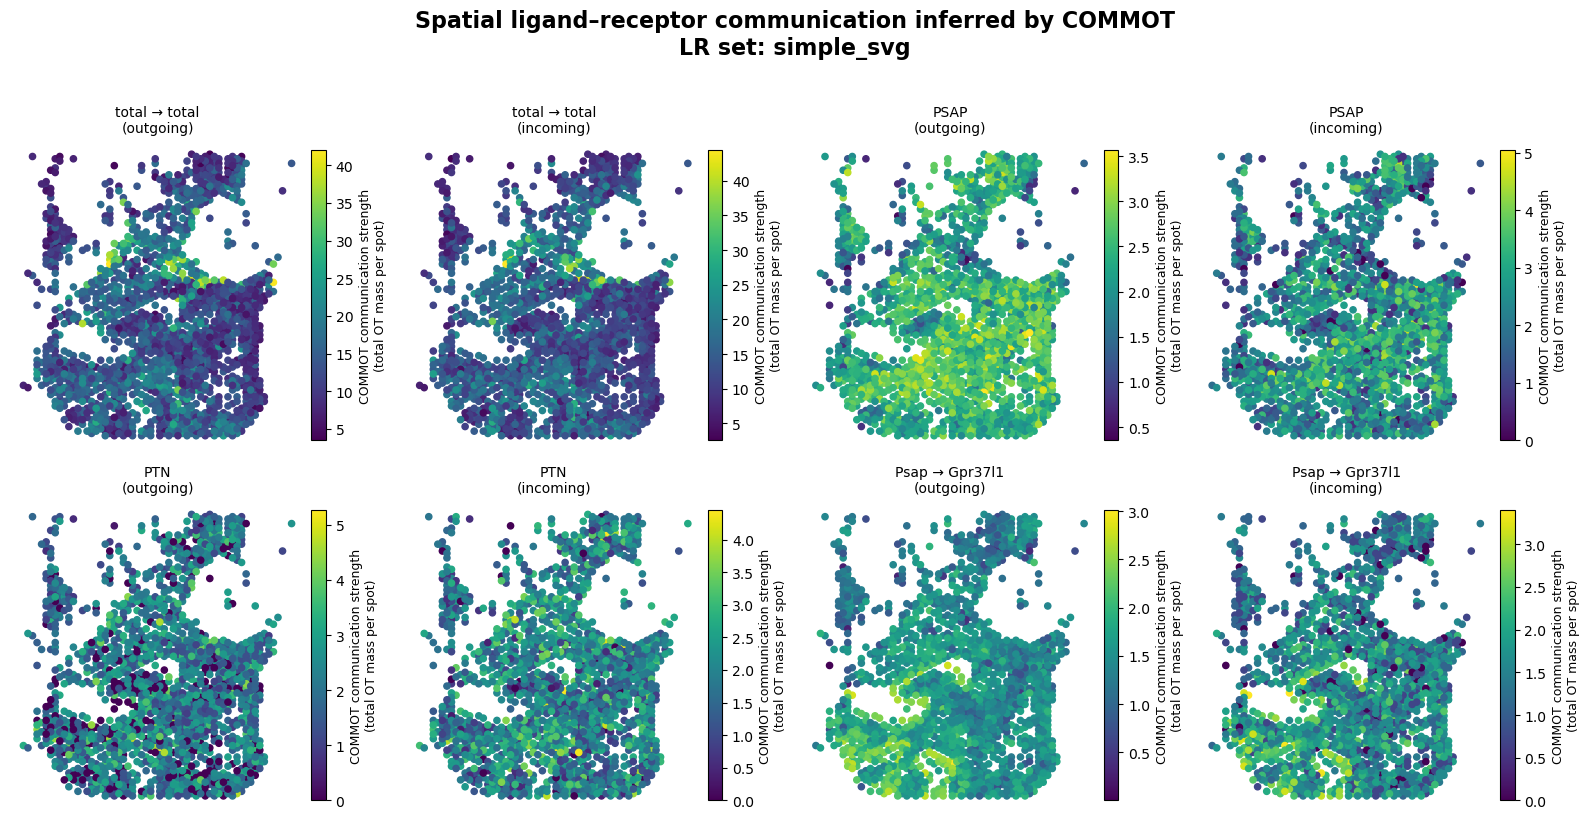

In [34]:
# plot top LR pairs for a chosen LR set
lr_set_name = "simple_svg"
ad = svg_results[lr_set_name]

# spatial coordinates
xy = ad.obsm["spatial"]

# COMMOT LR keys ranked by total communication
lr_keys = list(ad.obsp.keys())
lr_ranked = sorted(
    lr_keys,
    key=lambda k: ad.obsp[k].sum() if sparse.issparse(ad.obsp[k]) else np.sum(ad.obsp[k]),
    reverse=True
)

# choose top 4 LR pairs
top_lr = lr_ranked[:4]

# plot
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

panel = 0

for lr_key in top_lr:
    # sender / receiver values
    M = ad.obsp[lr_key]
    out_vals = np.array(M.sum(axis=1)).ravel()
    in_vals  = np.array(M.sum(axis=0)).ravel()

    lr_pretty = lr_key.replace("commot-cellchat-", "").replace("-", " → ", 1)

    for vals, direction in [(out_vals, "outgoing"), (in_vals, "incoming")]:
        ax = axes[panel]

        sca = ax.scatter(
            xy[:, 0],
            xy[:, 1],
            c=vals,
            s=20,
            cmap="viridis"
        )
        ax.invert_yaxis()
        ax.set_title(f"{lr_pretty}\n({direction})", fontsize=10)
        ax.axis("off")

        # colorbar
        cbar = fig.colorbar(sca, ax=ax, fraction=0.046, pad=0.02)
        cbar.set_label(
            "COMMOT communication strength\n(total OT mass per spot)",
            fontsize=9
        )

        panel += 1

fig.suptitle(
    "Spatial ligand–receptor communication inferred by COMMOT\n"
    f"LR set: {lr_set_name}",
    fontsize=16,
    fontweight='bold',
    y=1.02
)

plt.tight_layout()
plt.show()

Spot colors indicate the OT mass for sender and reciever spots.

OT mass is a relative, unitless measurement -> reflects signaling flow

closer LRs = more mass (cheaper transport) = spatially probable signaling

farther LRs = less mass = spatially contraint signaling

In [ ]:
# compare LR sets summary table

def top_totals_table(results_dict, top_n=20):
    # get keys from first result
    ref_name = list(results_dict.keys())[0]
    ref = results_dict[ref_name]
    pk, lk = split_pathway_lr_keys(ref)
    keys = pk if len(pk) > 0 else lk

    # rank by totals in reference
    ref_rank = rank_obsp_by_total(ref, keys)[:top_n]
    top_keys = [k for k, _ in ref_rank]

    out = pd.DataFrame(index=top_keys)
    for name, ad in results_dict.items():
        vals = []
        for k in top_keys:
            if k in ad.obsp:
                M = ad.obsp[k]
                vals.append(float(M.sum() if sparse.issparse(M) else np.sum(M)))
            else:
                vals.append(0.0)
        out[name] = vals
    return out

# summary table for SVG LR sets - cols are total OT mass
svg_tbl = top_totals_table(svg_results, top_n=20)
svg_tbl.style.format("{:.2e}")


,simple_svg,LR_svg,L_svg,R_svg,prevalence_svg
commot-cellchat-total-total,2.36e+04,2.01e+04,2.13e+04,2.28e+04,2.18e+04
commot-cellchat-PSAP,3.91e+03,3.91e+03,3.91e+03,3.91e+03,3.91e+03
commot-cellchat-PTN,3.22e+03,3.19e+03,3.23e+03,3.18e+03,3.23e+03
commot-cellchat-Psap-Gpr37l1,2.55e+03,2.55e+03,2.55e+03,2.55e+03,2.55e+03
commot-cellchat-FGF,2.30e+03,2.11e+03,2.11e+03,2.30e+03,2.11e+03
commot-cellchat-MK,1.69e+03,1.66e+03,1.69e+03,1.67e+03,1.69e+03
commot-cellchat-Psap-Gpr37,1.36e+03,1.36e+03,1.36e+03,1.36e+03,1.36e+03
commot-cellchat-VEGF,1.12e+03,1.02e+03,1.02e+03,1.12e+03,1.11e+03
commot-cellchat-GAS,8.98e+02,8.57e+02,8.98e+02,8.57e+02,8.98e+02
commot-cellchat-WNT,8.79e+02,4.05e+02,6.62e+02,8.56e+02,6.98e+02


### Top pathways for SVGs: 
**higher OT mass = spatial organization of LR spots allows for more signaling flow assuming OT model**

- PSAP
    - prosaposin protein (PSAP) processing saposins (glycoproteins) for lysosomal lipid degredation and activation of other pathways such as ERK & PI3K-Akt for cell proliferation
    - linked to glioma cell proliferaton (abnormal glial cells)

- PTN
    - pleiotrophin (PTN) binds a tyrosine phosphatase receptor to trigger downstream pathway activation of IRS-1, AKT, ERK, STAT3, Wnt, etc. for cell growth, neural development, angiogenesis, and others.
    - involved in neural migration, differentiation, synaptic plasticity, neuroprotection, and etc.

- Psap-Gpr37I1
    - involves PSAP -> activates g-protein coupled receptors GPR37 and GPR37L1 to initiate downstream pathways like ERK and cAMP activation
    - involved in astrocyte migration and neuroprotection

- FGF
    - fibroblast growth factor (FGF) bind to FGF receptors to trigger downstream pathways like MAPK for cell growth differentiation, and stem cell pluripotency
    - involved in neurogenesis, myelination, synapse formation, and metabolism in neural tissue

- MK
    - midkine (MK) growth factor binds cell surface receptors to activate pathways like MAPK and PI3K for cell growth, migration, and survival.
    - In neural tissue, MK is involved in development, neuroprotection, inflammation, and microglial (neural immune cells) activity regulation.

### SVG Null model (shuffled coords)

In [45]:
# null model testing with COMMOT
# shuffle spot locations and rerun COMMOT
n_shuffles = 5
null_svg_results = defaultdict(list)
for name, df in svg_lr_sets.items():
    print("Null model for LR set:", name)
    for i in range(n_shuffles):
        print(" Shuffle", i+1)
        ad = adata.copy()
        # shuffle spatial coordinates
        shuffled_xy = ad.obsm["spatial"].copy()
        np.random.shuffle(shuffled_xy)
        ad.obsm["spatial"] = shuffled_xy
        # run COMMOT
        ct.tl.spatial_communication(
            adata=ad,
            database_name="cellchat",
            df_ligrec=df,
            dis_thr=500,
            heteromeric=True,
            pathway_sum=True,
        )
        null_svg_results[name].append(ad)

Null model for LR set: simple_svg
 Shuffle 1
 Shuffle 2
 Shuffle 3
 Shuffle 4
 Shuffle 5
Null model for LR set: LR_svg
 Shuffle 1
 Shuffle 2
 Shuffle 3
 Shuffle 4
 Shuffle 5
Null model for LR set: L_svg
 Shuffle 1
 Shuffle 2
 Shuffle 3
 Shuffle 4
 Shuffle 5
Null model for LR set: R_svg
 Shuffle 1
 Shuffle 2
 Shuffle 3
 Shuffle 4
 Shuffle 5
Null model for LR set: prevalence_svg
 Shuffle 1
 Shuffle 2
 Shuffle 3
 Shuffle 4
 Shuffle 5


In [52]:
# save null models
output_dir_null = "/Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/mouse_svg_lr_sets_null"
os.makedirs(output_dir_null, exist_ok=True)
for name, ad_list in null_svg_results.items():
    for i, ad in enumerate(ad_list):
        output_path = os.path.join(output_dir_null, f"mouse_commot_{name}_null_{i+1}.h5ad")
        ad.write_h5ad(output_path)
        print(f"Saved null {name} shuffle {i+1} results to {output_path}")

Saved null simple_svg shuffle 1 results to /Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/mouse_svg_lr_sets_null/mouse_commot_simple_svg_null_1.h5ad
Saved null simple_svg shuffle 2 results to /Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/mouse_svg_lr_sets_null/mouse_commot_simple_svg_null_2.h5ad
Saved null simple_svg shuffle 3 results to /Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/mouse_svg_lr_sets_null/mouse_commot_simple_svg_null_3.h5ad
Saved null simple_svg shuffle 4 results to /Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/mouse_svg_lr_sets_null/mouse_commot_simple_svg_null_4.h5ad
Saved null simple_svg shuffle 5 results to /Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/mouse_svg_lr_sets_null/mouse_commot_simple_svg_null_5.h5ad
Saved null LR_svg shuffle 1 results to /Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/mouse_svg_lr_sets_null/mouse_commot_LR_svg_null_1.h5ad


In [46]:
# check null results
print("Null model COMMOT results for SVG LR sets:")
for name, ad_list in null_svg_results.items():
    print("\n==", name, "==")
    for i, ad in enumerate(ad_list):
        inv = commot_inventory(ad)
        print(f" Shuffle {i+1}: n_obsp: {inv['n_obsp']}, obsp head: {inv['obsp_keys_head']}")

Null model COMMOT results for SVG LR sets:

== simple_svg ==
 Shuffle 1: n_obsp: 539, obsp head: ['commot-cellchat-Gdf10-Acvr1b_Acvr2a', 'commot-cellchat-Ntf3-Ntrk3', 'commot-cellchat-Ntf3-Ntrk2', 'commot-cellchat-Edn3-Ednrb', 'commot-cellchat-Mstn-Acvr1b_Acvr2a', 'commot-cellchat-Mstn-Acvr1b_Acvr2b', 'commot-cellchat-Mstn-Tgfbr1_Acvr2a', 'commot-cellchat-Mstn-Tgfbr1_Acvr2b', 'commot-cellchat-Cxcl5-Ackr1', 'commot-cellchat-Trh-Trhr', 'commot-cellchat-Vegfb-Flt1', 'commot-cellchat-Kitl-Kit', 'commot-cellchat-Wnt3-Fzd7_Lrp6', 'commot-cellchat-Wnt3-Fzd9_Lrp6', 'commot-cellchat-Wnt3-Fzd1_Lrp6']
 Shuffle 2: n_obsp: 539, obsp head: ['commot-cellchat-Gdf10-Acvr1b_Acvr2a', 'commot-cellchat-Ntf3-Ntrk3', 'commot-cellchat-Ntf3-Ntrk2', 'commot-cellchat-Edn3-Ednrb', 'commot-cellchat-Mstn-Acvr1b_Acvr2a', 'commot-cellchat-Mstn-Acvr1b_Acvr2b', 'commot-cellchat-Mstn-Tgfbr1_Acvr2a', 'commot-cellchat-Mstn-Tgfbr1_Acvr2b', 'commot-cellchat-Cxcl5-Ackr1', 'commot-cellchat-Trh-Trhr', 'commot-cellchat-Vegfb-Fl

In [47]:
# look at significance of top pathways in real vs null model
def pathway_significance(real_ad, null_ads, top_n=10):
    pk, lk = split_pathway_lr_keys(real_ad)
    keys_to_rank = pk if len(pk) > 0 else lk
    top_paths = [k for k, _ in rank_obsp_by_total(real_ad, keys_to_rank)[:top_n]]

    results = []
    for path in top_paths:
        real_M = real_ad.obsp[path]
        real_total = real_M.sum() if sparse.issparse(real_M) else np.sum(real_M)

        null_totals = []
        for null_ad in null_ads:
            null_M = null_ad.obsp.get(path)
            if null_M is not None:
                null_total = null_M.sum() if sparse.issparse(null_M) else np.sum(null_M)
                null_totals.append(null_total)
            else:
                null_totals.append(0.0)

        mean_null = np.mean(null_totals)
        std_null = np.std(null_totals)
        z_score = (real_total - mean_null) / std_null if std_null > 0 else float('inf')

        results.append({
            "pathway": path,
            "real_total": real_total, # total OT mass in real data
            "mean_null_total": mean_null, # mean total OT mass in null data
            "std_null_total": std_null, # std dev of total OT mass in null data
            "z_score": z_score 
        })

    return pd.DataFrame(results)

# significance for SVG LR sets
print("Pathway significance for SVG LR sets:")
for name, ad in svg_results.items():
    null_ads = null_svg_results[name]
    sig_df = pathway_significance(ad, null_ads, top_n=10)
    print("\n==", name, "==")
    print(sig_df)
    

Pathway significance for SVG LR sets:

== simple_svg ==
                        pathway    real_total  mean_null_total  \
0   commot-cellchat-total-total  23581.567781     24283.459245   
1          commot-cellchat-PSAP   3913.538722      3912.339525   
2           commot-cellchat-PTN   3220.445945      3221.585519   
3  commot-cellchat-Psap-Gpr37l1   2553.745475      2553.178179   
4           commot-cellchat-FGF   2299.859771      2331.734160   
5            commot-cellchat-MK   1693.520968      1689.331529   
6    commot-cellchat-Psap-Gpr37   1359.793247      1359.161346   
7          commot-cellchat-VEGF   1120.045047      1121.246859   
8           commot-cellchat-GAS    897.766972       919.408891   
9           commot-cellchat-WNT    879.086612       979.773162   

   std_null_total    z_score  
0       16.498451 -42.542870  
1        0.991770   1.209148  
2        1.119823  -1.017637  
3        0.463183   1.224777  
4        1.584168 -20.120583  
5        1.554863   2.694411  


### Null Results Interpretation

- Tests if inferred CCC under COMMOT model depends on spatial organization of spots 
    - negative zscore = real tissue organization allows for less total OT mass than null -> spatial organization constrains the signalling pathway
    - positive zscore = real spatial organization allows for more total OT mass than null -> spatial organization enhances the signaling pathway

<br>

- Exremely negative z-scores (total, FGF, GAS & WNT) LR interaction pathways have less total OT mass than random spatial null models and are highly spatially contraint
    - Higher OT mass in null model suggests spatial structure constraints LR pathways 

- Positive z-scores (PSAP, Psap-Gpr37l1, MK, Psap-Gpr37) indicate the LR interaction pathways have higher signaling efficiency when spaitally organized compared to random spatial tissue arch
itecture.
    - Suggests co-localization of LR domains

***Tissue architecture can contrain or enhance signaling in pathways***

## HVGs
- simple HVGs
- L&R HVG
- ligand HVG
- receptor HVG
- 5% prevalence

In [36]:
# HVG LR sets
hvg_lr_sets = {
    "simple_hvg": lr_hvg,
    "LR_hvg" : lr_hvg_strict,
    "L_hvg" : lr_hvg_ligand,
    "R_hvg" : lr_hvg_receptor,
    "prevalence_hvg" : prevalence_lr_hvg,
}

hvg_results = {}

# run COMMOT for each LR set
for name, df in hvg_lr_sets.items():
    ad = adata.copy()  # use shallow copy
    ct.tl.spatial_communication(
        adata=ad,
        database_name="cellchat",
        df_ligrec=df,
        dis_thr=500,
        heteromeric=True,
        pathway_sum=True,
    )
    hvg_results[name] = ad

print(hvg_results.keys())

dict_keys(['simple_hvg', 'LR_hvg', 'L_hvg', 'R_hvg', 'prevalence_hvg'])


In [37]:
# look at results
print("COMMOT results for HVG LR sets:")
for name, ad in hvg_results.items():
    inv = commot_inventory(ad)
    print("\n==", name, "==")
    print("n_obsp:", inv["n_obsp"])
    print("obsp head:", inv["obsp_keys_head"])

COMMOT results for HVG LR sets:

== simple_hvg ==
n_obsp: 578
obsp head: ['commot-cellchat-Gdf10-Acvr1b_Acvr2a', 'commot-cellchat-Ntf3-Ntrk1', 'commot-cellchat-Ntf3-Ntrk3', 'commot-cellchat-Ntf3-Ntrk2', 'commot-cellchat-Edn3-Ednrb', 'commot-cellchat-Mstn-Acvr1b_Acvr2a', 'commot-cellchat-Mstn-Acvr1b_Acvr2b', 'commot-cellchat-Mstn-Tgfbr1_Acvr2a', 'commot-cellchat-Mstn-Tgfbr1_Acvr2b', 'commot-cellchat-Cxcl5-Ackr1', 'commot-cellchat-Trh-Trhr', 'commot-cellchat-Vegfb-Flt1', 'commot-cellchat-Kitl-Kit', 'commot-cellchat-Wnt3-Fzd7_Lrp6', 'commot-cellchat-Wnt3-Fzd9_Lrp6']

== LR_hvg ==
n_obsp: 197
obsp head: ['commot-cellchat-Pgf-Flt1', 'commot-cellchat-Wnt7a-Fzd7_Lrp6', 'commot-cellchat-Wnt7a-Fzd9_Lrp6', 'commot-cellchat-Wnt7a-Fzd1_Lrp6', 'commot-cellchat-Wnt7a-Fzd3_Lrp6', 'commot-cellchat-Wnt7a-Fzd6_Lrp6', 'commot-cellchat-Wnt7a-Fzd2_Lrp6', 'commot-cellchat-Fgf9-Fgfr1', 'commot-cellchat-Fgf9-Fgfr3', 'commot-cellchat-Fgf9-Fgfr2', 'commot-cellchat-Gdf10-Acvr1b_Acvr2a', 'commot-cellchat-Tgfb3-Ac

In [38]:
# save results
output_dir = "/Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/mouse_hvg_lr_sets"
os.makedirs(output_dir, exist_ok=True)
for name, ad in svg_results.items():
    output_path = os.path.join(output_dir, f"mouse_commot_{name}.h5ad")
    ad.write_h5ad(output_path)
    print(f"Saved {name} results to {output_path}")

Saved simple_svg results to /Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/mouse_hvg_lr_sets/mouse_commot_simple_svg.h5ad
Saved LR_svg results to /Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/mouse_hvg_lr_sets/mouse_commot_LR_svg.h5ad
Saved L_svg results to /Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/mouse_hvg_lr_sets/mouse_commot_L_svg.h5ad
Saved R_svg results to /Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/mouse_hvg_lr_sets/mouse_commot_R_svg.h5ad
Saved prevalence_svg results to /Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/mouse_hvg_lr_sets/mouse_commot_prevalence_svg.h5ad


In [39]:
# pathway-sum matrices vs LR pair matrices
print("Pathway vs LR matrices for HVG LR sets:")
for name, ad in  hvg_results.items():
    pk, lk = split_pathway_lr_keys(ad)
    print(name, "path:", len(pk), "lr:", len(lk))

Pathway vs LR matrices for HVG LR sets:
simple_hvg path: 0 lr: 578
LR_hvg path: 0 lr: 197
L_hvg path: 0 lr: 373
R_hvg path: 0 lr: 503
prevalence_hvg path: 0 lr: 302


In [40]:
# rank pathways by total communication strength
print("Top pathways by total communication strength for HVG LR sets:")
for name, ad in hvg_results.items():
    pk, lk = split_pathway_lr_keys(ad)
    keys_to_rank = pk if len(pk) > 0 else lk
    top = rank_obsp_by_total(ad, keys_to_rank)[:10]
    print("\nTOP in", name)
    for k, s in top:
        print(f"{s: .3e}", k)

Top pathways by total communication strength for HVG LR sets:

TOP in simple_hvg
 2.373e+04 commot-cellchat-total-total
 3.914e+03 commot-cellchat-PSAP
 3.220e+03 commot-cellchat-PTN
 2.554e+03 commot-cellchat-Psap-Gpr37l1
 2.300e+03 commot-cellchat-FGF
 1.693e+03 commot-cellchat-MK
 1.360e+03 commot-cellchat-Psap-Gpr37
 1.135e+03 commot-cellchat-VEGF
 8.978e+02 commot-cellchat-GAS
 8.853e+02 commot-cellchat-WNT

TOP in LR_hvg
 1.931e+04 commot-cellchat-total-total
 3.914e+03 commot-cellchat-PSAP
 2.632e+03 commot-cellchat-PTN
 2.554e+03 commot-cellchat-Psap-Gpr37l1
 2.147e+03 commot-cellchat-FGF
 1.420e+03 commot-cellchat-MK
 1.360e+03 commot-cellchat-Psap-Gpr37
 8.568e+02 commot-cellchat-Ptn-Sdc3
 8.474e+02 commot-cellchat-VEGF
 8.388e+02 commot-cellchat-Ptn-Ptprz1

TOP in L_hvg
 2.197e+04 commot-cellchat-total-total
 3.914e+03 commot-cellchat-PSAP
 3.229e+03 commot-cellchat-PTN
 2.554e+03 commot-cellchat-Psap-Gpr37l1
 2.147e+03 commot-cellchat-FGF
 1.695e+03 commot-cellchat-MK
 1.36

In [42]:
# per spot sender and receiver scores for top pathway in each HVG LR set
print("Adding top 3 sender/receiver scores for HVG LR sets")
for name, ad in hvg_results.items():
    pk, lk = split_pathway_lr_keys(ad)
    keys_to_rank = pk if len(pk) > 0 else lk
    top3 = [k for k, _ in rank_obsp_by_total(ad, keys_to_rank)[:3]]
    for i, k in enumerate(top3, 1):
        add_sender_receiver(ad, k, prefix=f"{name}_top{i}")

Adding top 3 sender/receiver scores for HVG LR sets


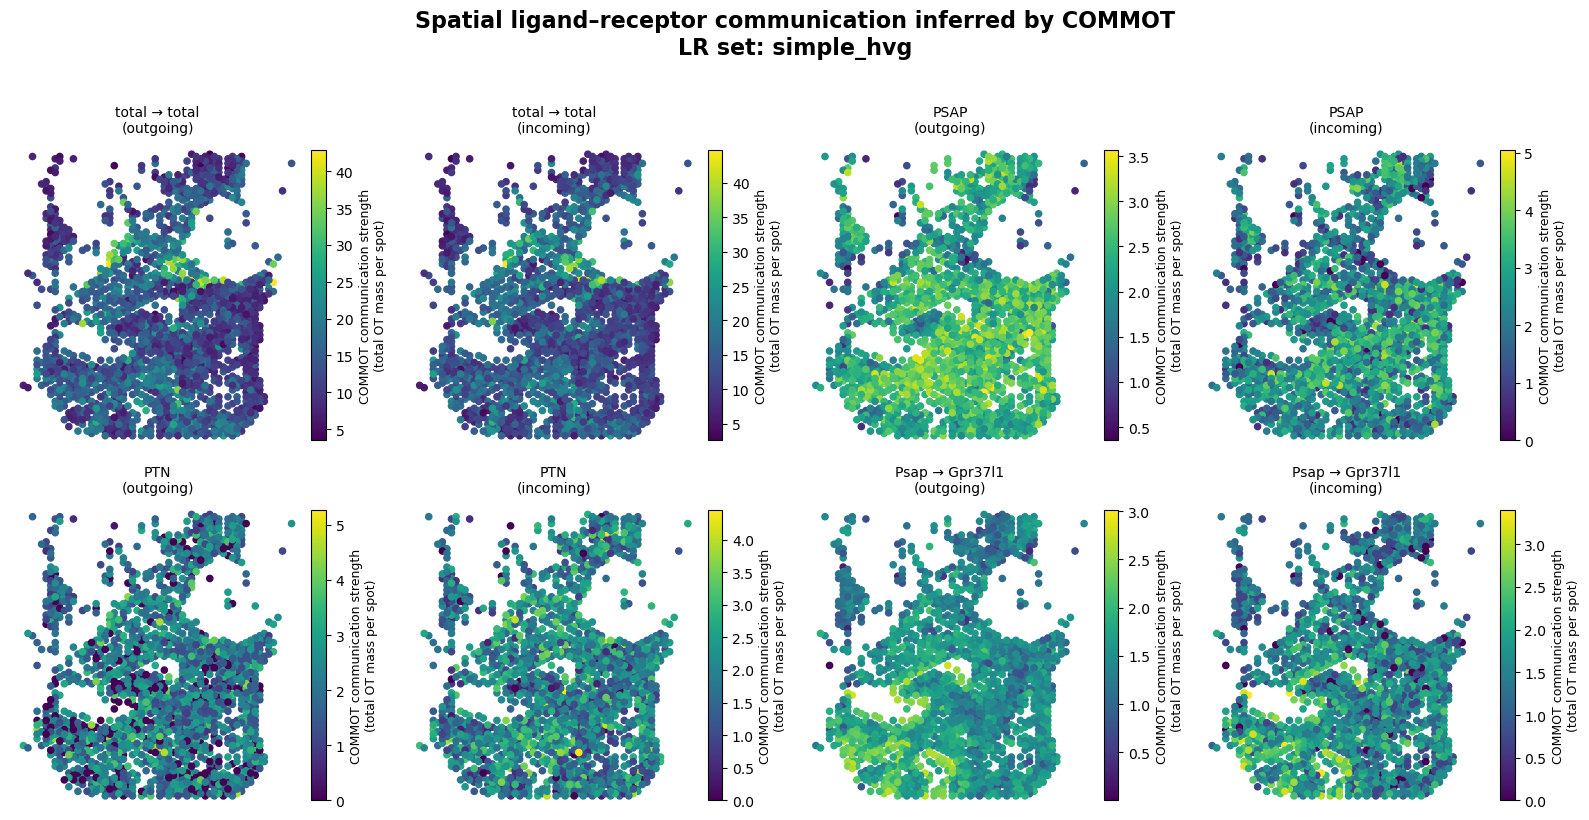

In [43]:
# plot top LR pairs for a chosen LR set
lr_set_name = "simple_hvg"
ad = hvg_results[lr_set_name]

# spatial coordinates
xy = ad.obsm["spatial"]

# COMMOT LR keys ranked by total communication
lr_keys = list(ad.obsp.keys())
lr_ranked = sorted(
    lr_keys,
    key=lambda k: ad.obsp[k].sum() if sparse.issparse(ad.obsp[k]) else np.sum(ad.obsp[k]),
    reverse=True
)

# choose top 4 LR pairs
top_lr = lr_ranked[:4]

# plot
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

panel = 0

for lr_key in top_lr:
    # sender / receiver values
    M = ad.obsp[lr_key]
    out_vals = np.array(M.sum(axis=1)).ravel()
    in_vals  = np.array(M.sum(axis=0)).ravel()

    lr_pretty = lr_key.replace("commot-cellchat-", "").replace("-", " → ", 1)

    for vals, direction in [(out_vals, "outgoing"), (in_vals, "incoming")]:
        ax = axes[panel]

        sca = ax.scatter(
            xy[:, 0],
            xy[:, 1],
            c=vals,
            s=20,
            cmap="viridis"
        )
        ax.invert_yaxis()
        ax.set_title(f"{lr_pretty}\n({direction})", fontsize=10)
        ax.axis("off")

        # colorbar
        cbar = fig.colorbar(sca, ax=ax, fraction=0.046, pad=0.02)
        cbar.set_label(
            "COMMOT communication strength\n(total OT mass per spot)",
            fontsize=9
        )

        panel += 1

fig.suptitle(
    "Spatial ligand–receptor communication inferred by COMMOT\n"
    f"LR set: {lr_set_name}",
    fontsize=16,
    fontweight='bold',
    y=1.02
)

plt.tight_layout()
plt.show()

In [44]:
# summary table for HVG LR sets
hvg_tbl = top_totals_table(hvg_results, top_n=20)
hvg_tbl.style.format("{:.2e}")

,simple_hvg,LR_hvg,L_hvg,R_hvg,prevalence_hvg
commot-cellchat-total-total,2.37e+04,1.93e+04,2.20e+04,2.18e+04,2.18e+04
commot-cellchat-PSAP,3.91e+03,3.91e+03,3.91e+03,3.91e+03,3.91e+03
commot-cellchat-PTN,3.22e+03,2.63e+03,3.23e+03,2.63e+03,3.23e+03
commot-cellchat-Psap-Gpr37l1,2.55e+03,2.55e+03,2.55e+03,2.55e+03,2.55e+03
commot-cellchat-FGF,2.30e+03,2.15e+03,2.15e+03,2.30e+03,2.11e+03
commot-cellchat-MK,1.69e+03,1.42e+03,1.69e+03,1.43e+03,1.69e+03
commot-cellchat-Psap-Gpr37,1.36e+03,1.36e+03,1.36e+03,1.36e+03,1.36e+03
commot-cellchat-VEGF,1.14e+03,8.47e+02,8.62e+02,1.12e+03,1.11e+03
commot-cellchat-GAS,8.98e+02,6.48e+02,8.98e+02,6.48e+02,8.98e+02
commot-cellchat-WNT,8.85e+02,5.88e+02,7.77e+02,8.76e+02,7.01e+02


### Top pathways for HVGs:
- PSAP
- PTN
- Psap-Gpr37
- FGF
- MK

**same as SVGs**

### HVG Null model (shuffled coords):

In [49]:
# null model testing with COMMOT
# shuffle spot locations and rerun COMMOT
n_shuffles = 5
null_hvg_results = defaultdict(list)
for name, df in hvg_lr_sets.items():
    print("Null model for LR set:", name)
    for i in range(n_shuffles):
        print(" Shuffle", i+1)
        ad = adata.copy()
        # shuffle spatial coordinates
        shuffled_xy = ad.obsm["spatial"].copy()
        np.random.shuffle(shuffled_xy)
        ad.obsm["spatial"] = shuffled_xy
        # run COMMOT
        ct.tl.spatial_communication(
            adata=ad,
            database_name="cellchat",
            df_ligrec=df,
            dis_thr=500,
            heteromeric=True,
            pathway_sum=True,
        )
        null_hvg_results[name].append(ad)

Null model for LR set: simple_hvg
 Shuffle 1
 Shuffle 2
 Shuffle 3
 Shuffle 4
 Shuffle 5
Null model for LR set: LR_hvg
 Shuffle 1
 Shuffle 2
 Shuffle 3
 Shuffle 4
 Shuffle 5
Null model for LR set: L_hvg
 Shuffle 1
 Shuffle 2
 Shuffle 3
 Shuffle 4
 Shuffle 5
Null model for LR set: R_hvg
 Shuffle 1
 Shuffle 2
 Shuffle 3
 Shuffle 4
 Shuffle 5
Null model for LR set: prevalence_hvg
 Shuffle 1
 Shuffle 2
 Shuffle 3
 Shuffle 4
 Shuffle 5


In [50]:
# check null results
print("Null model COMMOT results for SVG LR sets:")
for name, ad_list in null_hvg_results.items():
    print("\n==", name, "==")
    for i, ad in enumerate(ad_list):
        inv = commot_inventory(ad)
        print(f" Shuffle {i+1}: n_obsp: {inv['n_obsp']}, obsp head: {inv['obsp_keys_head']}")

Null model COMMOT results for SVG LR sets:

== simple_hvg ==
 Shuffle 1: n_obsp: 578, obsp head: ['commot-cellchat-Gdf10-Acvr1b_Acvr2a', 'commot-cellchat-Ntf3-Ntrk1', 'commot-cellchat-Ntf3-Ntrk3', 'commot-cellchat-Ntf3-Ntrk2', 'commot-cellchat-Edn3-Ednrb', 'commot-cellchat-Mstn-Acvr1b_Acvr2a', 'commot-cellchat-Mstn-Acvr1b_Acvr2b', 'commot-cellchat-Mstn-Tgfbr1_Acvr2a', 'commot-cellchat-Mstn-Tgfbr1_Acvr2b', 'commot-cellchat-Cxcl5-Ackr1', 'commot-cellchat-Trh-Trhr', 'commot-cellchat-Vegfb-Flt1', 'commot-cellchat-Kitl-Kit', 'commot-cellchat-Wnt3-Fzd7_Lrp6', 'commot-cellchat-Wnt3-Fzd9_Lrp6']
 Shuffle 2: n_obsp: 578, obsp head: ['commot-cellchat-Gdf10-Acvr1b_Acvr2a', 'commot-cellchat-Ntf3-Ntrk1', 'commot-cellchat-Ntf3-Ntrk3', 'commot-cellchat-Ntf3-Ntrk2', 'commot-cellchat-Edn3-Ednrb', 'commot-cellchat-Mstn-Acvr1b_Acvr2a', 'commot-cellchat-Mstn-Acvr1b_Acvr2b', 'commot-cellchat-Mstn-Tgfbr1_Acvr2a', 'commot-cellchat-Mstn-Tgfbr1_Acvr2b', 'commot-cellchat-Cxcl5-Ackr1', 'commot-cellchat-Trh-Trhr',

In [51]:
# save null models
output_dir_null = "/Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/mouse_hvg_lr_sets_null"
os.makedirs(output_dir_null, exist_ok=True)
for name, ad_list in null_hvg_results.items():
    for i, ad in enumerate(ad_list):
        output_path = os.path.join(output_dir_null, f"mouse_commot_{name}_null_{i+1}.h5ad")
        ad.write_h5ad(output_path)
        print(f"Saved null {name} shuffle {i+1} results to {output_path}")

Saved null simple_hvg shuffle 1 results to /Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/mouse_hvg_lr_sets_null/mouse_commot_simple_hvg_null_1.h5ad
Saved null simple_hvg shuffle 2 results to /Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/mouse_hvg_lr_sets_null/mouse_commot_simple_hvg_null_2.h5ad
Saved null simple_hvg shuffle 3 results to /Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/mouse_hvg_lr_sets_null/mouse_commot_simple_hvg_null_3.h5ad
Saved null simple_hvg shuffle 4 results to /Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/mouse_hvg_lr_sets_null/mouse_commot_simple_hvg_null_4.h5ad
Saved null simple_hvg shuffle 5 results to /Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/mouse_hvg_lr_sets_null/mouse_commot_simple_hvg_null_5.h5ad
Saved null LR_hvg shuffle 1 results to /Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/mouse_hvg_lr_sets_null/mouse_commot_LR_hvg_null_1.h5ad


In [53]:
# significance for HVG LR sets
print("Pathway significance for HVG LR sets:")
for name, ad in hvg_results.items():
    null_ads = null_hvg_results[name]
    sig_df = pathway_significance(ad, null_ads, top_n=10)
    print("\n==", name, "==")
    print(sig_df)

Pathway significance for HVG LR sets:

== simple_hvg ==
                        pathway    real_total  mean_null_total  \
0   commot-cellchat-total-total  23725.670757     24428.291224   
1          commot-cellchat-PSAP   3913.538722      3912.949129   
2           commot-cellchat-PTN   3220.156957      3221.448462   
3  commot-cellchat-Psap-Gpr37l1   2553.745475      2553.416505   
4           commot-cellchat-FGF   2299.859771      2329.563611   
5            commot-cellchat-MK   1693.420244      1690.070087   
6    commot-cellchat-Psap-Gpr37   1359.793247      1359.532624   
7          commot-cellchat-VEGF   1135.019631      1137.589386   
8           commot-cellchat-GAS    897.766972       918.311540   
9           commot-cellchat-WNT    885.324937       984.537494   

   std_null_total    z_score  
0        7.035032 -99.874521  
1        0.398728   1.478682  
2        0.980092  -1.317739  
3        0.212008   1.551687  
4        2.468012 -12.035534  
5        0.866503   3.866294  


In [ ]:
# plot null results for HVGs vs SVGs
lr_set_name = "simple_hvg"
real_ad = hvg_results[lr_set_name]
null_ads = null_hvg_results[lr_set_name]
# spatial coordinates
xy = real_ad.obsm["spatial"]
# COMMOT LR keys ranked by total communication
lr_keys = list(real_ad.obsp.keys())
lr_ranked = sorted(
    lr_keys,
    key=lambda k: real_ad.obsp[k].sum() if sparse.issparse(real_ad.obsp[k]) else np.sum(real_ad.obsp[k]),
    reverse=True
)
# choose top LR pair
top_lr = lr_ranked[0]
# plot real vs null
fig, axes = plt.subplots(1, n_shuffles + 1, figsize=(4 * (n_shuffles + 1), 4))
# real data
M_real = real_ad.obsp[top_lr]
out_vals_real = np.array(M_real.sum(axis=1)).ravel()
ax = axes[0]
sca = ax.scatter(
    xy[:, 0],
    xy[:, 1],
    c=out_vals_real,
    s=20,
    cmap="viridis"
)
ax.invert_yaxis()
ax.set_title(f"Real data\n{top_lr}", fontsize=10)
ax.axis("off")
cbar = fig.colorbar(sca, ax=ax, fraction=0.046, pad=0.02)
cbar.set_label(
    "COMMOT communication strength\n(total OT mass per spot)",
    fontsize=9
)
# null data
for i, null_ad in enumerate(null_ads):
    M_null = null_ad.obsp.get(top_lr)
    if M_null is not None:
        out_vals_null = np.array(M_null.sum(axis=1)).ravel()
    else:
        out_vals_null = np.zeros(real_ad.n_obs)
    ax = axes[i + 1]
    sca = ax.scatter(
        xy[:, 0],
        xy[:, 1],
        c=out_vals_null,
        s=20,
        cmap="viridis"
    )
    ax.invert_yaxis()
    ax.set_title(f"Null shuffle {i+1}\n{top_lr}", fontsize=10)
    ax.axis("off")
    cbar = fig.colorbar(sca, ax=ax, fraction=0.046, pad=0.02)
    cbar.set_label(
        "COMMOT communication strength\n(total OT mass per spot)",
        fontsize=9
    )
fig.suptitle(
    "Spatial ligand–receptor communication inferred by COMMOT\n"
    f"LR set: {lr_set_name} (top pair: {top_lr})",
    fontsize=16,
    fontweight='bold',
    y=1.02
)
plt.tight_layout()
plt.show()

### Null Results Interpretation

- Extremely negative z scores (total, FGF, GAS, and WNT) for HVGs are the same as those for SVGs compared to a spatially null model. 
    - Indicates spatial organizaiton of CCC is driven by shared LR set and tissue architecture, not based on SVGs and HVGs.
    - This makes sense as there was high overlap between HVGs and SVGs
        - HVGs still include spatial information when tested against a spatially shuffled dataset


## OVERALL: 
***The similarity of SVG- and HVG-based null results indicates that spatial communication constraints arise primarily from tissue geometry, while SVG filtering refines the biological specificity of ligand–receptor interactions rather than to introduce spatial structure.***

## Unfiltered genes

In [ ]:
# commot for unfiltered LR pairs
lr_unfiltered = lr_expr.copy()   

unfiltered_results = {}

name = "unfiltered_lr"
ad = adata.copy()

ct.tl.spatial_communication(
    adata=ad,
    database_name="cellchat",
    df_ligrec=lr_unfiltered,
    dis_thr=500,
    heteromeric=True,
    pathway_sum=True,
)

unfiltered_results[name] = ad
print(unfiltered_results.keys())


dict_keys(['unfiltered_lr'])


In [100]:
# look at results
print("COMMOT results for unfiltered LR sets:")
for name, ad in unfiltered_results.items():
    inv = commot_inventory(ad)
    print("\n==", name, "==")
    print("n_obsp:", inv["n_obsp"])
    print("obsp head:", inv["obsp_keys_head"])

COMMOT results for unfiltered LR sets:

== unfiltered_lr ==
n_obsp: 302
obsp head: ['commot-cellchat-Tgfb2-Acvr1b_Tgfbr2', 'commot-cellchat-Tgfb2-Tgfbr1_Tgfbr2', 'commot-cellchat-Tgfb2-Acvr1c_Tgfbr2', 'commot-cellchat-Tgfb2-Acvr1_Tgfbr1_Tgfbr2', 'commot-cellchat-Nppc-Npr2', 'commot-cellchat-Pros1-Tyro3', 'commot-cellchat-Pros1-Axl', 'commot-cellchat-Tgfb3-Acvr1b_Tgfbr2', 'commot-cellchat-Tgfb3-Tgfbr1_Tgfbr2', 'commot-cellchat-Tgfb3-Acvr1c_Tgfbr2', 'commot-cellchat-Tgfb3-Acvr1_Tgfbr1_Tgfbr2', 'commot-cellchat-Igf2-Igf1r', 'commot-cellchat-Igf2-Igf2r', 'commot-cellchat-Igf2-Itgav_Itgb3', 'commot-cellchat-Igf2-Itga6_Itgb4']


In [101]:
# pathway-sum matrices vs LR pair matrices
print("Pathway vs LR matrices for unfiltered LR sets:")
for name, ad in  hvg_results.items():
    pk, lk = split_pathway_lr_keys(ad)
    print(name, "path:", len(pk), "lr:", len(lk))

Pathway vs LR matrices for unfiltered LR sets:
simple_hvg path: 0 lr: 302
LR_hvg path: 0 lr: 322
L_hvg path: 0 lr: 399
R_hvg path: 0 lr: 519
prevalence_hvg path: 0 lr: 302
unfiltered_lr path: 0 lr: 302


In [102]:
# rank pathways by total communication strength
print("Top pathways by total communication strength for unfiltered LR sets:")
for name, ad in unfiltered_results.items():
    pk, lk = split_pathway_lr_keys(ad)
    keys_to_rank = pk if len(pk) > 0 else lk
    top = rank_obsp_by_total(ad, keys_to_rank)[:10]
    print("\nTOP in", name)
    for k, s in top:
        print(f"{s: .3e}", k)

Top pathways by total communication strength for unfiltered LR sets:

TOP in unfiltered_lr
 2.184e+04 commot-cellchat-total-total
 3.914e+03 commot-cellchat-PSAP
 3.229e+03 commot-cellchat-PTN
 2.554e+03 commot-cellchat-Psap-Gpr37l1
 2.107e+03 commot-cellchat-FGF
 1.695e+03 commot-cellchat-MK
 1.360e+03 commot-cellchat-Psap-Gpr37
 1.114e+03 commot-cellchat-VEGF
 8.978e+02 commot-cellchat-GAS
 8.351e+02 commot-cellchat-Ptn-Ncl


In [103]:
# per spot sender and receiver scores for top pathway in unfiltered LR set
print("Adding top 3 sender/receiver scores for unfiltered LR set:")
for name, ad in hvg_results.items():
    pk, lk = split_pathway_lr_keys(ad)
    keys_to_rank = pk if len(pk) > 0 else lk
    top3 = [k for k, _ in rank_obsp_by_total(ad, keys_to_rank)[:3]]
    for i, k in enumerate(top3, 1):
        add_sender_receiver(ad, k, prefix=f"{name}_top{i}")

Adding top 3 sender/receiver scores for unfiltered LR set:


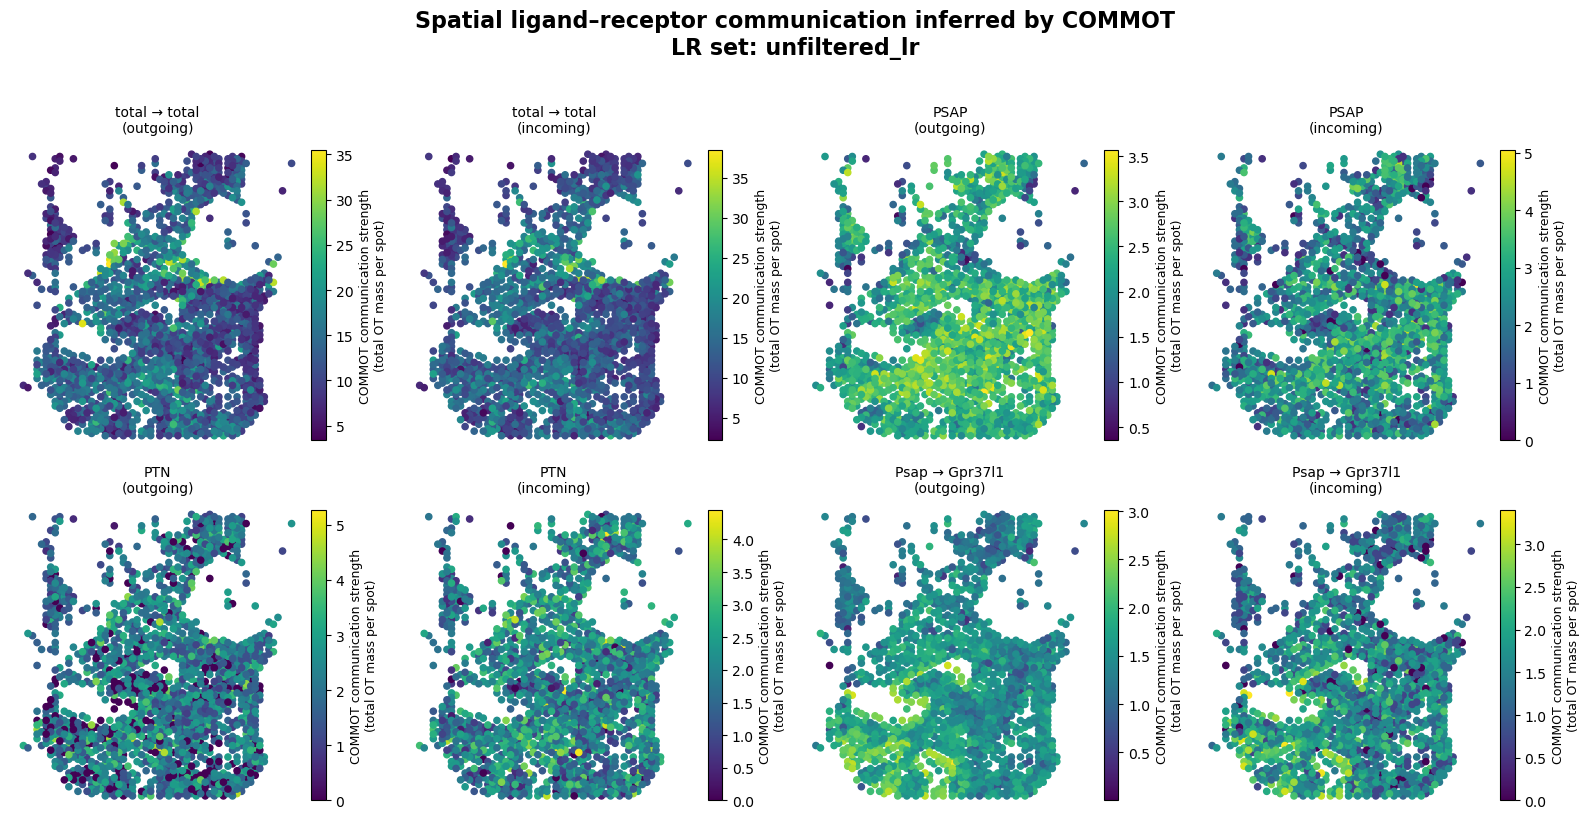

In [104]:
# plot top LR pairs for a chosen LR set
lr_set_name = "unfiltered_lr"
ad = unfiltered_results[lr_set_name]

# spatial coordinates
xy = ad.obsm["spatial"]

# COMMOT LR keys ranked by total communication
lr_keys = list(ad.obsp.keys())
lr_ranked = sorted(
    lr_keys,
    key=lambda k: ad.obsp[k].sum() if sparse.issparse(ad.obsp[k]) else np.sum(ad.obsp[k]),
    reverse=True
)

# choose top 4 LR pairs
top_lr = lr_ranked[:4]

# plot
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

panel = 0

for lr_key in top_lr:
    # sender / receiver values
    M = ad.obsp[lr_key]
    out_vals = np.array(M.sum(axis=1)).ravel()
    in_vals  = np.array(M.sum(axis=0)).ravel()

    lr_pretty = lr_key.replace("commot-cellchat-", "").replace("-", " → ", 1)

    for vals, direction in [(out_vals, "outgoing"), (in_vals, "incoming")]:
        ax = axes[panel]

        sca = ax.scatter(
            xy[:, 0],
            xy[:, 1],
            c=vals,
            s=20,
            cmap="viridis"
        )
        ax.invert_yaxis()
        ax.set_title(f"{lr_pretty}\n({direction})", fontsize=10)
        ax.axis("off")

        # colorbar
        cbar = fig.colorbar(sca, ax=ax, fraction=0.046, pad=0.02)
        cbar.set_label(
            "COMMOT communication strength\n(total OT mass per spot)",
            fontsize=9
        )

        panel += 1

fig.suptitle(
    "Spatial ligand–receptor communication inferred by COMMOT\n"
    f"LR set: {lr_set_name}",
    fontsize=16,
    fontweight='bold',
    y=1.02
)

plt.tight_layout()
plt.show()

In [105]:
# summary table for unfiltered LR sets
unfilt_tbl = top_totals_table(unfiltered_results, top_n=20)
unfilt_tbl.style.format("{:.2e}")

,unfiltered_lr
commot-cellchat-total-total,2.18e+04
commot-cellchat-PSAP,3.91e+03
commot-cellchat-PTN,3.23e+03
commot-cellchat-Psap-Gpr37l1,2.55e+03
commot-cellchat-FGF,2.11e+03
commot-cellchat-MK,1.69e+03
commot-cellchat-Psap-Gpr37,1.36e+03
commot-cellchat-VEGF,1.11e+03
commot-cellchat-GAS,8.98e+02
commot-cellchat-Ptn-Ncl,8.35e+02


### Top pathways for unfiltered genes: same as SVGs and HVGs

In [109]:
# check differences between LR sets for SVG, HVG, unfiltered
def compare_lr_sets(sets_dict):
    lr_sets = {}
    for name, df in sets_dict.items():
        pairs = set()
        for _, row in df.iterrows():
            lig = row[LIG]
            rec = row[REC]
            pairs.add((lig, rec))
        lr_sets[name] = pairs

    all_names = list(lr_sets.keys())
    n = len(all_names)

    comparison = pd.DataFrame(index=all_names, columns=all_names, dtype=int)

    for i in range(n):
        for j in range(n):
            set_i = lr_sets[all_names[i]]
            set_j = lr_sets[all_names[j]]
            intersection = set_i.intersection(set_j)
            comparison.iloc[i, j] = len(intersection)

    return comparison

# compare SVG LR sets
svg_comparison = compare_lr_sets(svg_lr_sets)
print("SVG LR sets comparison:")
print(svg_comparison)   
# compare HVG LR sets
hvg_comparison = compare_lr_sets(hvg_lr_sets)
print("\nHVG LR sets comparison:")
print(hvg_comparison)   
# compare unfiltered LR set to SVG and HVG simple sets
unfiltered_comparison = compare_lr_sets({
    "unfiltered_lr": lr_unfiltered,
    "simple_svg": lr_svg,
    "simple_hvg": lr_hvg,
})
print("\nUnfiltered vs SVG and HVG LR sets comparison:")
print(unfiltered_comparison)

SVG LR sets comparison:
                 simple_svg  LR_svg  L_svg  R_svg  prevalence_svg:
simple_svg            256.0   109.0  191.0  235.0            256.0
LR_svg                109.0   116.0  116.0  116.0            109.0
L_svg                 191.0   116.0  250.0  187.0            191.0
R_svg                 235.0   116.0  187.0  421.0            235.0
prevalence_svg:       256.0   109.0  191.0  235.0            256.0

HVG LR sets comparison:
                simple_hvg  LR_hvg  L_hvg  R_hvg  prevalence_hvg
simple_hvg           261.0   131.0  235.0  242.0           261.0
LR_hvg               131.0   152.0  152.0  152.0           131.0
L_hvg                235.0   152.0  321.0  252.0           235.0
R_hvg                242.0   152.0  252.0  450.0           242.0
prevalence_hvg       261.0   131.0  235.0  242.0           261.0

Unfiltered vs SVG and HVG LR sets comparison:
               unfiltered_lr  simple_svg  simple_hvg
unfiltered_lr          261.0       256.0       261.0
simple

### **SVGs:**
- Receptor SVG dominates -> R_svg is the largests SVG LR set and heavily overlaps with simple_svg. Most SVG signal in this sample is carried by receptors
- Ligand-only SVG is intermediate -> L_svg overlaps with simple_svg to a lesser extent than receptors. Ligands are spatially structured, but less than receptors

***Spatial organization of LR signaling is primarily driven by receptor spatial variability***

### **HVGs:**
- R_hvg is also the largest in terms of LR pairs -> receptor variability also dominates in HVGs
- HVG LR pairs > SVG LR pairs -> HVGs may capture cell-state variability that is not spatially organized

### **All 3:**
- HVG filtering did not removed any LR pairs (HVG LR pairs = unfiltered LR pairs)
- SVG filtering only removed 5 LR pairs that were likely non-spatial

***SVG filtering removed a small number of non-spatial interactions while HVG filtering retains the full LR landscape***


In [48]:
# look at 5 interactions removed by SVG filtering but kept by HVG filtering
removed_by_svg = hvg_lr_sets["simple_hvg"].merge(
    svg_lr_sets["simple_svg"],
    on=[LIG, REC],
    how="left",
    indicator=True
)
removed_by_svg = removed_by_svg[removed_by_svg["_merge"] == "left_only"]
print("Interactions removed by SVG filtering but kept by HVG filtering:")
print(removed_by_svg[[LIG, REC]].head(5))

Interactions removed by SVG filtering but kept by HVG filtering:
         0                   1
69   Nodal  Acvr1c_Acvr2b_Cfc1
75   Inhbb       Acvr1c_Acvr2b
79  Wnt10a           Fzd6_Lrp5
81  Wnt10a           Fzd9_Lrp5
85    Wnt2           Fzd6_Lrp5


These LR pairs that are not included in SVG are highly variable, but do not contain important spatial information. The majority of these LR interation pathways are involved in developmental processes (Wnt, Nodal, and Inhbb ligands).